In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

from PIL import Image, ImageFile
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


%matplotlib notebook
import os
import numpy as np

import torch.utils.data as td 
import torchvision as tv

import matplotlib.pyplot as plt
import nntools as nt

import pandas as pd
import json
import random
import pickle

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Image loader

In [3]:
def image_loader(image_name):
    image = Image.open(image_name)
    
    loader = transforms.Compose([
    transforms.Resize((128,128)),  # scale imported image
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)])  # transform it into a torch tensor

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
def imshow(image, ax=plt, title=None, flag=False):
    with torch.no_grad():
        i = image.clone()
        i = i.squeeze(0)
        i = i.to('cpu').numpy()
        i = np.moveaxis(i, [0, 1, 2], [2, 0, 1]) 
        i = (i + 1) / 2
        # clamp the image data to [0,1]
        i[i < 0] = 0
        i[i > 1] = 1 
        ax.imshow(i) 
        if title is not None:
            ax.title(title)
        ax.axis('off') 
#         ax.pause(0.001)

## Part C

### load the pretrained model

In [5]:
# Need this cell for loading generators later
class ResidualBlock(nn.Module):
    """
    define residual block
    """
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        
        self.model = []
        
        self.model.append(nn.ReflectionPad2d(1))
        self.model.append(nn.Conv2d(in_channels,in_channels, 3))
        self.model.append(nn.InstanceNorm2d(in_channels))
        self.model.append(nn.ReLU())
        
        self.model.append(nn.ReflectionPad2d(1))
        self.model.append(nn.Conv2d(in_channels,in_channels, 3))
        self.model.append(nn.InstanceNorm2d(in_channels))
        self.model = nn.Sequential(*self.model)
        
    def forward(self, x):
        return x + self.model(x)

class Generator(nn.Module):
    """
    6 residual blocks for 128 × 128 training images
    """
    def __init__(self, input_channels):
        super(Generator, self).__init__()
        self.model = []
        
        in_channels = input_channels
        out_channels = 64
        
        # c7s1-64
        self.model.append(nn.ReflectionPad2d(in_channels))
        self.model.append(nn.Conv2d(in_channels,out_channels, 7))
        self.model.append(nn.InstanceNorm2d(out_channels))
        self.model.append(nn.ReLU())
        
        # d128, d256
        for _ in range(2):
            in_channels = out_channels
            out_channels *= 2
            self.model.append(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1))
            self.model.append(nn.InstanceNorm2d(out_channels))
            self.model.append(nn.ReLU())
            
        # R256 * 6
        in_channels = out_channels # 256
        for _ in range(6):
            self.model.append(ResidualBlock(in_channels))
            
        # u128, u64
        for _ in range(2):
            out_channels //= 2
            self.model.append(nn.Upsample(scale_factor=2))
            self.model.append(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1))
            self.model.append(nn.InstanceNorm2d(out_channels))
            self.model.append(nn.ReLU())
            in_channels = out_channels
        
        # c7s1-3
        out_channels = 3
        self.model.append(nn.ReflectionPad2d(input_channels))
        self.model.append(nn.Conv2d(in_channels,out_channels, 7))
        self.model.append(nn.Tanh())
        
        self.model = nn.Sequential(*self.model)
         
    def forward(self, x): 
        y = self.model(x)
        return y

In [6]:
# loading generators
saving_dir = 'cycle_gan_vangogh2photo/final_model_'
G = torch.load(saving_dir+'G')
F = torch.load(saving_dir+'F')

### Test vangogh $\rightarrow$ photo

In [7]:
dataset_root_dir = './vangogh2photo/test'

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


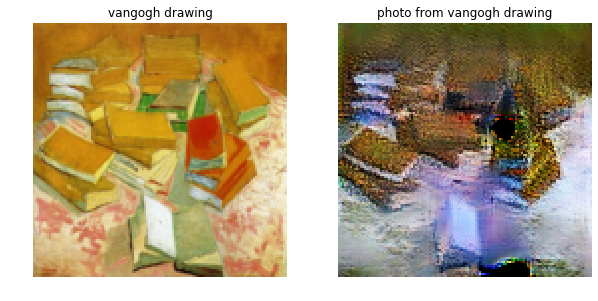

In [8]:
# randomly choose a picture
test1 = dataset_root_dir + 'A/'
pic_name = random.choice(os.listdir(test1))

vangogh = image_loader(test1+pic_name)
v2p = G(vangogh)

fig, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].title.set_text('vangogh drawing')
imshow(vangogh, axes[0])

axes[1].title.set_text('photo from vangogh drawing')
imshow(v2p, axes[1])

### Test photo $\rightarrow$ vangogh

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


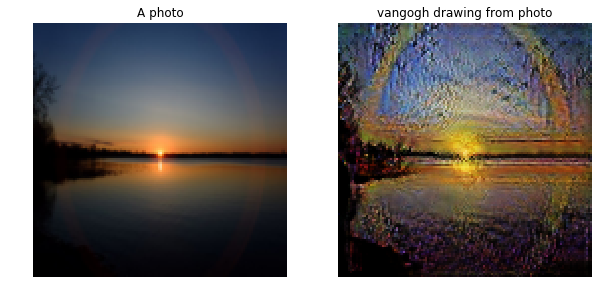

In [9]:
# randomly choose a picture
test2 = dataset_root_dir + 'B/'
pic_name = random.choice(os.listdir(test2))

photo = image_loader(test2+pic_name)
p2v = F(photo)

fig, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].title.set_text('A photo')
imshow(photo, axes[0])

axes[1].title.set_text('vangogh drawing from photo')
imshow(p2v, axes[1])

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


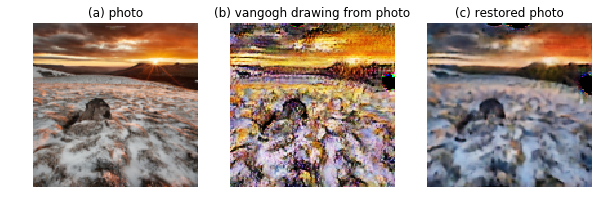

In [28]:
# randomly choose a picture
test2 = dataset_root_dir + 'B/'
pic_name = random.choice(os.listdir(test2))

photo = image_loader(test2+pic_name)
p2v = F(photo)

v2p = G(p2v)

fig, axes = plt.subplots(1, 3, figsize=(10,10))

axes[0].title.set_text('(a) photo')
imshow(photo, axes[0])

axes[1].title.set_text('(b) vangogh drawing from photo')
imshow(p2v, axes[1])

axes[2].title.set_text('(c) restored photo')
imshow(v2p, axes[2])